# ENVS2004: Urban climate lab

This lab uses Python in a "Notebook" interface. You'll not need to run any code, but you can see how software such as Python can be used to analyse data. 

In the lab you will compare model outputs and observations from the Bureau of Meteorology over a domain centred on Sydney. The analysis covers 28 days in January 2017.

Provide answers to questions Q1 - Q8.

In [13]:
# initialisation

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from dask.distributed import Client

datapath = '/g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf'
plotpath = '/g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/figures'
stationpath = '/g/data/ce10/users/mjl561/observations/AWS/au-2000_2024_5min'
cycle_path = '/scratch/ce10/mjl561/cylc-run/rns_ostia/share/cycle'

local_time = True
local_time_offset = 10
exps = ['E5L_1_L_CCI','BR2_1_L_CCI_no_urban']
ymin, xmin = -35.5, 149
ymax, xmax = -32.5, 152.5

try:
    print(client)
except Exception:
    client = Client()

<Client: 'tcp://127.0.0.1:39367' processes=7 threads=7>


In [2]:
# load land sea mask
lsm = xr.open_dataset(f'{datapath}/land_sea_mask/{exps[0]}_land_sea_mask.nc').isel(time=0)['land_binary_mask']
lsm = lsm.sel(latitude=slice(ymin,ymax), longitude=slice(xmin,xmax))

In [3]:
ymin, ymax = round(float(lsm.latitude.min()), 1), round(float(lsm.latitude.max()), 1)
xmin, xmax = round(float(lsm.longitude.min()), 1), round(float(lsm.longitude.max()), 1)
print(f'bottom left corner: ({ymin}, {xmin})')
print(f'top right corner: ({ymax}, {xmax})')

bottom left corner: (-35.5, 149.0)
top right corner: (-32.5, 152.5)


## Q1
Familiarise yourself with the modelled domain, e.g. using google maps and enter the following lat/lon coordinates: 

bottom left corner (lat, lon): (-35.0, 149.5)\
top right corner (lat, lon): (-32.5, 153.0)

Now, with reference to the figure below, describe how you expect average temperature in this domain to be affected by topography or surface elevation?

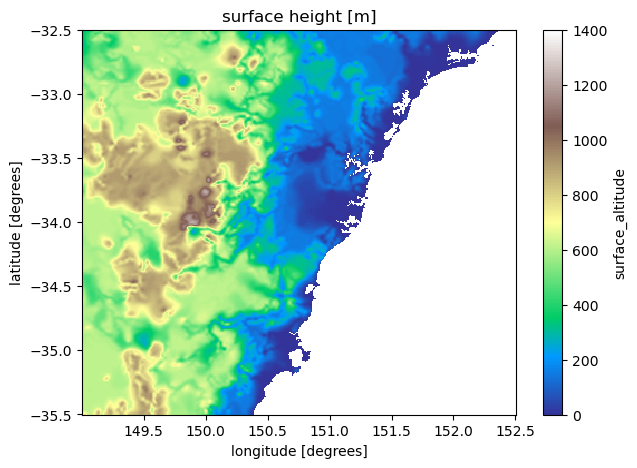

In [4]:
variable = 'surface_altitude'

ds = xr.open_dataset(f'{datapath}/{variable}/{exps[0]}_{variable}.nc')
ds = ds.sel(latitude=slice(ymin,ymax), longitude=slice(xmin,xmax))
ds = ds.mean('time')
# keep land points only using land sea mask
ds = ds.where(lsm==1)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5),sharey=True)                      
ds[variable].plot(ax=ax, cmap='terrain', vmin=0, vmax=1400, extend='neither')
ax.set_title('surface height [m]')
plt.show()

## Q2:
Now we will consider the outputs from two model simulations: one with an urban representation (right panel), and one with urban areas removed, replaced with vegetation from adjacent grid cells (left panel). Simulations have an approximate horizontal grid resolution of 1 km. Within a single model grid cell, the effects of sub-grid (smaller-scale) processes can be considered "blended" together.

a. How does your description in Q1 compare with the modelled air temperature in the plot on the left (with no urban representation)?\
b. Explain the difference between modelled air temperature in the left and right panels.\
c. What is the name of the temperature phenomenon apparent in the right hand plot?

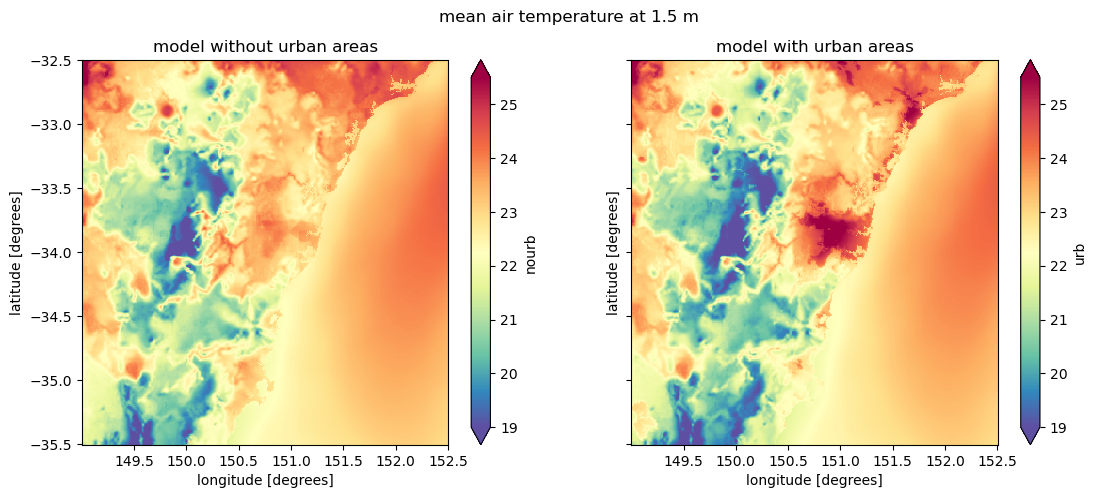

In [5]:
variable = 'air_temperature_1p5m'

# open data
ds = xr.Dataset()
ds['nourb'] = xr.open_dataset(f'{datapath}/{variable}/{exps[1]}_{variable}.nc')['air_temperature']
ds['urb'] = xr.open_dataset(f'{datapath}/{variable}/{exps[0]}_{variable}.nc')['air_temperature']

# subset and convert to local time and update timezone
ds = ds.sel(latitude=slice(ymin,ymax), longitude=slice(xmin,xmax))
ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
ds.time.attrs.update({'timezone': 'AEST'})

# plot figures
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(13,5),sharey=True)
ds['nourb'].mean('time').plot(ax=axes[0], cmap = 'Spectral_r', vmin=19, vmax=25.5)
ds['urb'].mean('time').plot(ax=axes[1], cmap = 'Spectral_r', vmin=19, vmax=25.5)

axes[0].set_title('model without urban areas')
axes[1].set_title('model with urban areas')
fig.suptitle('mean air temperature at 1.5 m')
plt.show()

## Q3:
Below we will load data from four Bureau of Meteorology stations, roughly spread from east to west of the Sydney, and compare them to model outputs. 

a. Looking at satellite images (e.g. using google with the latitude/longitdue listed below), describe the geography within a few hundred metres of Bureau observing station locations:

    66137: BANKSTOWN AIRPORT AWS: (-33.9176,150.9837)
    66212: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE): (-33.8338,151.0718)
    66196: SYDNEY HARBOUR (WEDDING CAKE WEST): (-33.8405,151.2643)
    67108: BADGERYS CREEK AWS: (-33.8969,150.7281)

b. Of these, which stations will be most/least affected by urban influences on air temperature?\
c. Will any of these stations capture all of the expected urban influence on air temperature? Why or why not?

In [6]:
# load observations
obs_fname = f'{stationpath}/all_stations_air_temperature_from_2013-01-01.nc'
obs_ds = xr.open_dataset(obs_fname)
station_ids = ['66137','66212','66196','67108']

# get data in simulation period
obs = obs_ds[station_ids].to_dataframe().loc['2017-01']
# select only obs that align with ds model times
obs = obs.loc[ds.time.values]

In [7]:
# print station information
for station in station_ids:
    name = obs_ds[station].station_name
    lat = obs_ds[station].latitude
    lon = obs_ds[station].longitude
    print(f'{station}: {name}: ({lat},{lon})')

66137: BANKSTOWN AIRPORT AWS: (-33.9176,150.9837)
66212: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE): (-33.8338,151.0718)
66196: SYDNEY HARBOUR (WEDDING CAKE WEST): (-33.8405,151.2643)
67108: BADGERYS CREEK AWS: (-33.8969,150.7281)


## Q4:
Now consider the below plots of average air temperature observations at various Bureau station locations, compared with the average air temperature across the simulation domain. The observation temperature is represented by the colour of the circle using the values of the colorbar (i.e. 20°C - 26°C).

a. Describe differences in observed air temperature, and what might be causing these differences.\
b. How do the observed air temperatures compare to modelled air temperature in the two simulations?


Text(0.5, 0.98, 'mean air temperature at 1.5 m')

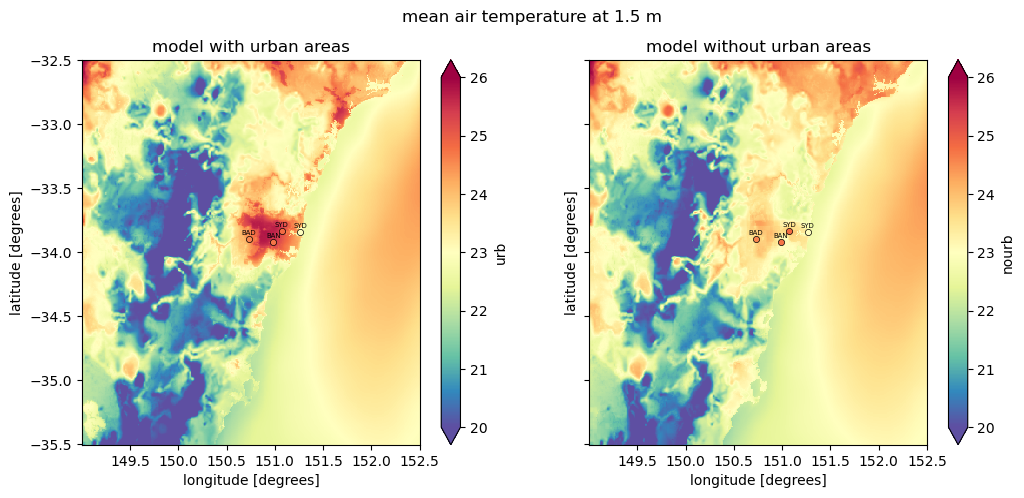

In [8]:
# plot figures
fig,axes = plt.subplots(nrows=1,ncols=2, figsize=(12,5), sharey=True)
                        
for ax, exp in zip(axes.flatten(), ['urb','nourb']):
    subset = ds[exp].mean('time')
    # subset = ds[exp].sel(latitude=slice(-34.75,-33),longitude=slice(150,152)).mean('time')
    im = subset.plot(ax=ax, cmap = 'Spectral_r', vmin=20, vmax=26)
    # include obsevations
    for station in station_ids:
        name = obs_ds[station].station_name
        lat, lon = obs_ds[station].latitude, obs_ds[station].longitude
        obs_val = obs[station].mean()
        ax.scatter(lon,lat, c=obs_val, norm=im.norm, 
                   cmap=im.cmap, marker='o', s=20, edgecolors='k', linewidth=0.5, zorder=10)
        ax.annotate(text=name[:3], xycoords='data', xy=(lon,lat), xytext=(0,3),
                textcoords='offset points', fontsize=5,color='k',ha='center', zorder=10)
        

axes[0].set_title('model with urban areas')
axes[1].set_title('model without urban areas')
fig.suptitle('mean air temperature at 1.5 m')

## Q5:
Below we plot the diurnal average air temperature at a particular Bureau of Metorology site: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE). 

With reference to the diurnal plots of temperature, which simulation is better matching the observations? Note differences and hypothesise why these differences might occur, considering the Bureau site locations and the resolution of the model.

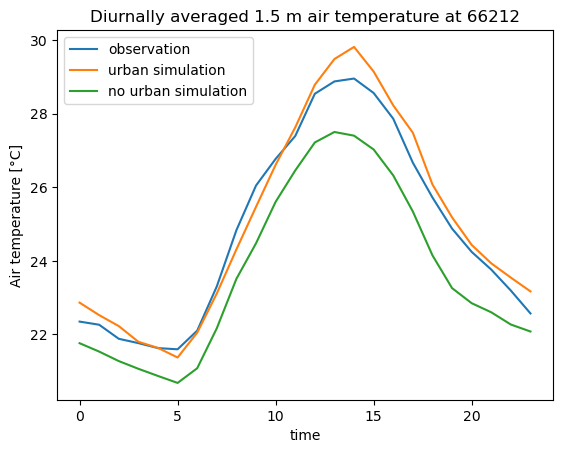

In [9]:
# focus on one location: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE): (-33.8338,151.0718)
station = '66212'
lat, lon = obs_ds[station].latitude, obs_ds[station].longitude
# get simulation data nearest this point
sim_ts = ds.sel(latitude=lat, longitude=lon, method='nearest').to_dataframe()[['urb','nourb']]
# concatenate obs and sim data
df = pd.concat([obs[station],sim_ts], axis=1)
# rename obs column
df = df.rename(columns={station:'observation','urb':'urban simulation','nourb':'no urban simulation'})
# calculate diurnal mean
df_diurnal = df.groupby(df.index.hour).mean()

# plot with observations column in black
df_diurnal.plot()
plt.title(f'Diurnally averaged 1.5 m air temperature at {station}')
plt.ylabel('Air temperature [°C]')
plt.show()

## Q6
We will now compare the surface energy fluxes between the simulation with and without urban representation at a particular location. As we are comparing model outputs, we are not limited to locations of Bureau of Meteorology observing stations. We choose the [population centre of Sydney](https://rastinseysan.medium.com/using-census-data-and-gis-to-find-the-centre-of-population-for-sydney-greater-metropolitan-area-10f2a64b74e3) (as many people living West as East of this point, and as many people living North as South). This point is Ermington, near Parramatta, usually described as being in Sydney's "Western Suburbs" (but more accurately its centre).

Describe the differences in the diurnal plot of surface energy fluxes below. Note that the simulation with an urban representation has solid lines, and the simulation without an urban represenation has dashed lines.

In [10]:
def open_sim_data(exp):

    def open_variable(variable):
        ds = xr.open_dataset(f'{datapath}/{variable}/{exp}_{variable}.nc')
        ds_var = list(ds.keys())[0]
        da = ds[ds_var]
        return da
   
    # open urban data
    ds = xr.Dataset()
    variable = 'surface_net_shortwave_flux'
    ds[variable] = open_variable(variable)
    variable = 'surface_net_longwave_flux'
    ds[variable] = open_variable(variable)
    variable = 'latent_heat_flux'
    ds[variable] = open_variable(variable)
    variable = 'sensible_heat_flux'
    ds[variable] = open_variable(variable)
    # variable = 'ground_heat_flux'
    # da = open_variable(variable)
    # ds[variable] = da.drop_vars('soil_model_level_number')

    ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
    ds.time.attrs.update({'timezone': 'AEST'})

    return ds

urb = open_sim_data(exps[0]).sel(latitude=slice(ymin,ymax), longitude=slice(xmin,xmax)).compute()
nourb = open_sim_data(exps[1]).sel(latitude=slice(ymin,ymax), longitude=slice(xmin,xmax)).compute()

In [11]:
# focus on one location: ERMINGTON (-33.814, 151.056)
lat, lon = (-33.814, 151.056)
df_urb = urb.sel(latitude=lat, longitude=lon, method='nearest').to_dataframe().drop(columns=['latitude','longitude'])
df_nourb = nourb.sel(latitude=lat, longitude=lon, method='nearest').to_dataframe().drop(columns=['latitude','longitude'])

# calculate storage heat flux as the residual of other fluxes, with:
#   ∆Qs = SW_net + LW_net - Qle - Qh
df_urb['storage_heat_flux'] = df_urb['surface_net_shortwave_flux'] + df_urb['surface_net_longwave_flux'] \
                               - df_urb['latent_heat_flux'] - df_urb['sensible_heat_flux']
df_nourb['storage_heat_flux'] = df_nourb['surface_net_shortwave_flux'] + df_nourb['surface_net_longwave_flux'] \
                               - df_nourb['latent_heat_flux'] - df_nourb['sensible_heat_flux']

# # calculate diurnal mean
df_urb_diurnal = df_urb.groupby(df_urb.index.hour).mean()
df_nourb_diurnal = df_nourb.groupby(df_urb.index.hour).mean()

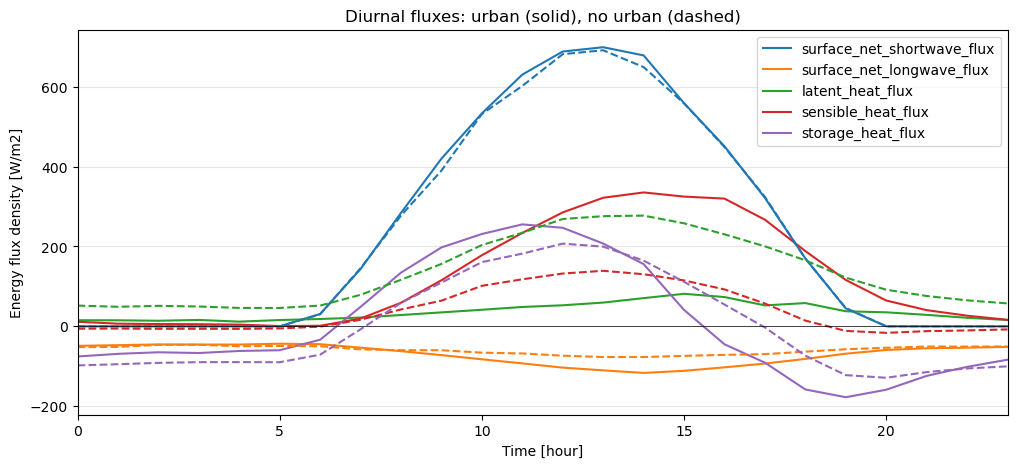

In [12]:
# plot diurnal profile
fig,ax = plt.subplots(figsize=(12,5),
                        sharey=True)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_urb_diurnal.plot(ax=ax, ls='solid',color=colors)
df_nourb_diurnal.plot(ax=ax, ls='dashed', color=colors, legend=False)
ax.hlines(y=0,xmin=0,xmax=23, color='k', lw=0.5)
ax.set_xlim(0,23)
ax.grid(axis='y', color='0.9')
ax.set_ylabel('Energy flux density [W/m2]')
ax.set_xlabel('Time [hour]')
ax.set_title('Diurnal fluxes: urban (solid), no urban (dashed)')
plt.show()

## Q7: 
What physical processes explain the differences in the average diurnal surface heat fluxes between simulations? (urban: solid, no urban: dashed)

## Q8
With reference to surface fluxes, propose two urban design solutions that might reduce urban air temperatures and hypothesise impacts on the thermal comfort of local inhabitants.